<a href="https://colab.research.google.com/github/rajadevineni/Income_classification/blob/main/income_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries and dataset

In [169]:
!pip install feature_engine

In [170]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pathlib import Path

pd.pandas.set_option('display.max_columns', None)
%matplotlib inline

## Grid Search import

In [171]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Load dataset

In [286]:
# load dataset
# Dataset is extracted from https://sci2s.ugr.es/keel/dataset.php?cod=192

path = "https://raw.githubusercontent.com/rajadevineni/Income_classification/main/adult.csv"
data = pd.read_csv(path)
print('Number of records in the Dataset: ', len(data))
print('Number of features in the Dataset: ', data.shape[1])
data.head(5)

Number of records in the Dataset:  48842
Number of features in the Dataset:  15


,Age,Workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


# Inspecting and exploring the data

## Setting up Target variable

* Since the target variable "Class" is in string we need to convert it to Binary variable for the predictions, Hence we create a new binary variable callled "Target"

In [324]:
data['Class'] = data['Class'].replace('>50K',1)
data['Class'] = data['Class'].replace('<=50K',0)

In [320]:
data['Class'].value_counts()

<=50K    37155
>50K     11687
Name: Class, dtype: int64

In [322]:
(data[data['Class']=='>50K'].shape[0]/data.shape[0])*100

23.928176569346054

In [18]:
data.head(5)

,Age,Workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


## Types of variables



In [19]:
# List for categorical variables
categorical = [var for var in data.columns if data[var].dtype=='O']

# List for numerical variables
numerical = [var for var in data.columns if data[var].dtype!='O']

# list of variables that contain year information
year_vars = [var for var in numerical if 'Yr' in var or 'Year' in var]

#To identify discrete variables- numerical variables with less than 20 unique values 
# List for discrete variables
discrete = [var for var in numerical if len(data[var].unique()) < 20 and var not in year_vars]

# List for continuous variables
continuous = [var for var in numerical if var not in discrete and var not in [
    'id', 'target'] and var not in year_vars]

print(f'There are {len(categorical)} categorical variables:',categorical)
print(f'There are {len(numerical)} numerical variables:',numerical)
print(f'There are {len(year_vars)} temporal variables:',year_vars)
print(f'There are {len(discrete)} discrete variables:', discrete)
print(f'There are {len(continuous)} continuous variables:', continuous)

There are 9 categorical variables: ['Workclass', 'Education', 'Marital-status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Native-country', 'Class']
There are 6 numerical variables: ['Age', 'Fnlwgt', 'Education-num', 'Capital-gain', 'Capital-loss', 'Hours-per-week']
There are 0 temporal variables: []
There are 1 discrete variables: ['Education-num']
There are 5 continuous variables: ['Age', 'Fnlwgt', 'Capital-gain', 'Capital-loss', 'Hours-per-week']


## Inspecting Data

### Checking for null values in the dataset

* There are null values in Workclass, Occupation and Native-country column

In [20]:
print(data.isna().sum())
#print(data.isnull().mean())

Age                  0
Workclass         2799
Fnlwgt               0
Education            0
Education-num        0
Marital-status       0
Occupation        2809
Relationship         0
Race                 0
Sex                  0
Capital-gain         0
Capital-loss         0
Hours-per-week       0
Native-country     857
Class                0
dtype: int64


### Inspecting the variable values

* Education-num column is the ordinal representation of Education column, therefore we can drop Education-num column

In [21]:
for var in data.columns:
    print(var, data[var].unique()[0:20], '\n')

Age [25 38 28 44 18 34 29 63 24 55 65 36 26 58 48 43 20 37 40 72] 

Workclass ['Private' 'Local-gov' nan 'Self-emp-not-inc' 'Federal-gov' 'State-gov'
 'Self-emp-inc' 'Without-pay' 'Never-worked'] 

Fnlwgt [226802  89814 336951 160323 103497 198693 227026 104626 369667 104996
 184454 212465  82091 299831 279724 346189 444554 128354  60548  85019] 

Education ['11th' 'HS-grad' 'Assoc-acdm' 'Some-college' '10th' 'Prof-school'
 '7th-8th' 'Bachelors' 'Masters' 'Doctorate' '5th-6th' 'Assoc-voc' '9th'
 '12th' '1st-4th' 'Preschool'] 

Education-num [ 7  9 12 10  6 15  4 13 14 16  3 11  5  8  2  1] 

Marital-status ['Never-married' 'Married-civ-spouse' 'Widowed' 'Divorced' 'Separated'
 'Married-spouse-absent' 'Married-AF-spouse'] 

Occupation ['Machine-op-inspct' 'Farming-fishing' 'Protective-serv' nan
 'Other-service' 'Prof-specialty' 'Craft-repair' 'Adm-clerical'
 'Exec-managerial' 'Tech-support' 'Sales' 'Priv-house-serv'
 'Transport-moving' 'Handlers-cleaners' 'Armed-Forces'] 

Relationship 

### cardinality (number of different categories)

In [134]:
data.nunique()

Age                  74
Workclass             8
Fnlwgt            28523
Education            16
Education-num        16
Marital-status        7
Occupation           14
Relationship          6
Race                  5
Sex                   2
Capital-gain        123
Capital-loss         99
Hours-per-week       96
Native-country       41
Class                 2
dtype: int64

# Exploratory analysis on the dataset

In [23]:
data.describe()

,Age,Fnlwgt,Education-num,Capital-gain,Capital-loss,Hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


### Creating correlation matrix
* There is no significant correlation between any features

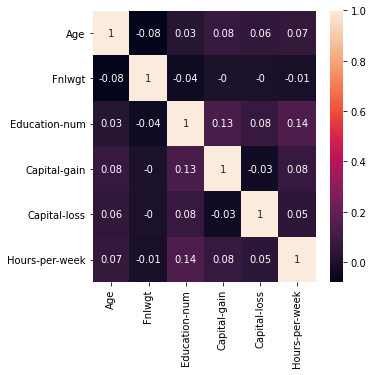

In [71]:
# data.corr(method='pearson', min_periods=1)
# Correlation matrix
correlation_matrix = data.corr().round(2)
figure = plt.figure(figsize=(5, 5))
sns.heatmap(data=correlation_matrix, annot=True)

## Exploring distribution and outliers in the dataset

### Capital gain distribution based on Income class
* This distribution graphs tells us that the outliers based on capital-gains are mostly in >50K class. 
* IF we choose to put a cap based on Capital-Gain then the outliers can be filtered out from Capital-gain>20000 

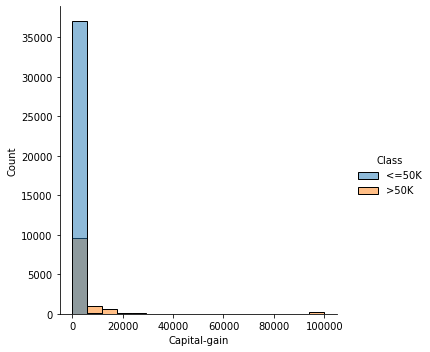

In [111]:
ax = sns.displot(data, x="Capital-gain", hue ='Class')
plt.show()

### Distibution of Fnlwgt based on income Class
* This graph is skewed towards right, we will perform a scalar transformation on this variable in upcoming fature engineering steps

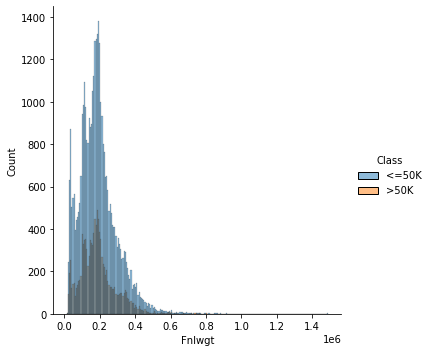

In [112]:
ax = sns.displot(data, x="Fnlwgt", hue ='Class')
plt.show()

### Income vs Age
* There are some out liers bases on the Age with respect to both categories of Income. 
* The records with Age above 70 can be filtered inorder to remove the ourliers

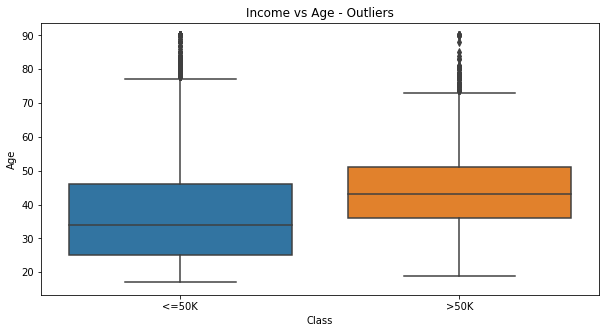

In [113]:
f, ax = plt.subplots(figsize=(10, 5))
ax = sns.boxplot(x="Class", y="Age", data=data)
ax.set_title("Income vs Age - Outliers")
plt.show()

### Frequency distribution of workclass

* We can see that the working class other than "Private" has very lower count  than 5000 observations for respective category.
* We have also seen in the previous section that there are **2799 missing values** in "Workclass" column which is would all combine to form another category. Hence, using *imputation_method='missing'* would be resonable in this case.

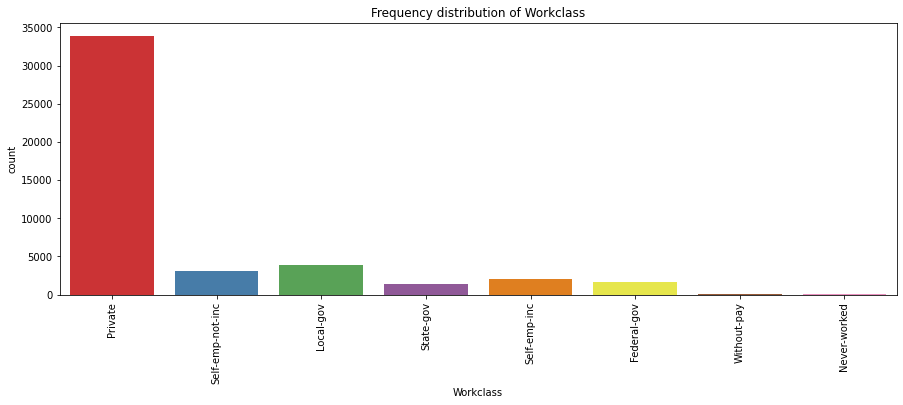

In [114]:
f, ax = plt.subplots(figsize=(15, 5))
ax = sns.countplot(x="Workclass", data=data, palette="Set1")
ax.set_title("Frequency distribution of Workclass")
ax.set_xticklabels(data.Workclass.value_counts().index, rotation=90)
plt.show()

### Frequency distribution of Occupation

* We can see that the Occupation variable has many categories with healthy distributions and only 4 categories such as Tech-support, Armed-Forces and Exec-managerial have less observations. 
* We have also seen in the previous section that there are **2809 missing values** in "Occupation" column. Since there are multiple categories with similar counts,we can create a new missing category using *imputation_method='missing'*

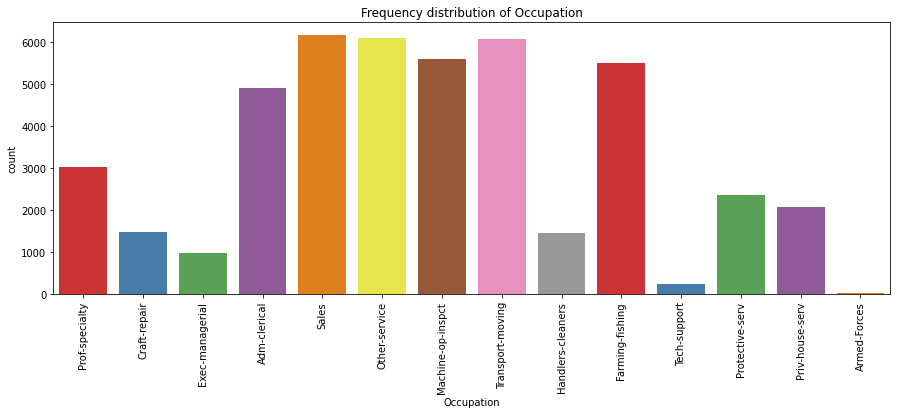

Prof-specialty       6172
Craft-repair         6112
Exec-managerial      6086
Adm-clerical         5611
Sales                5504
Other-service        4923
Machine-op-inspct    3022
Transport-moving     2355
Handlers-cleaners    2072
Farming-fishing      1490
Tech-support         1446
Protective-serv       983
Priv-house-serv       242
Armed-Forces           15
Name: Occupation, dtype: int64

In [127]:
f, ax = plt.subplots(figsize=(15, 5))
ax = sns.countplot(x="Occupation", data=data, palette="Set1")
ax.set_title("Frequency distribution of Occupation")
ax.set_xticklabels(data.Occupation.value_counts().index, rotation=90)
plt.show()
data['Occupation'].value_counts()

### Frequency distribution of Native-country

* We can see that the Native-country variable has many countries in the variable but ***89.7%*** observations have ***United States*** as the country.
* We have also seen in the previous section that there are **857 missing values** in "Native-country" column. Those missing values can be assigned new missing category using *imputation_method='missing'*. 
* In the later part of pre-processing pipeline, we can groups infrequent countires altogether into one new category called *'Rare'*. 

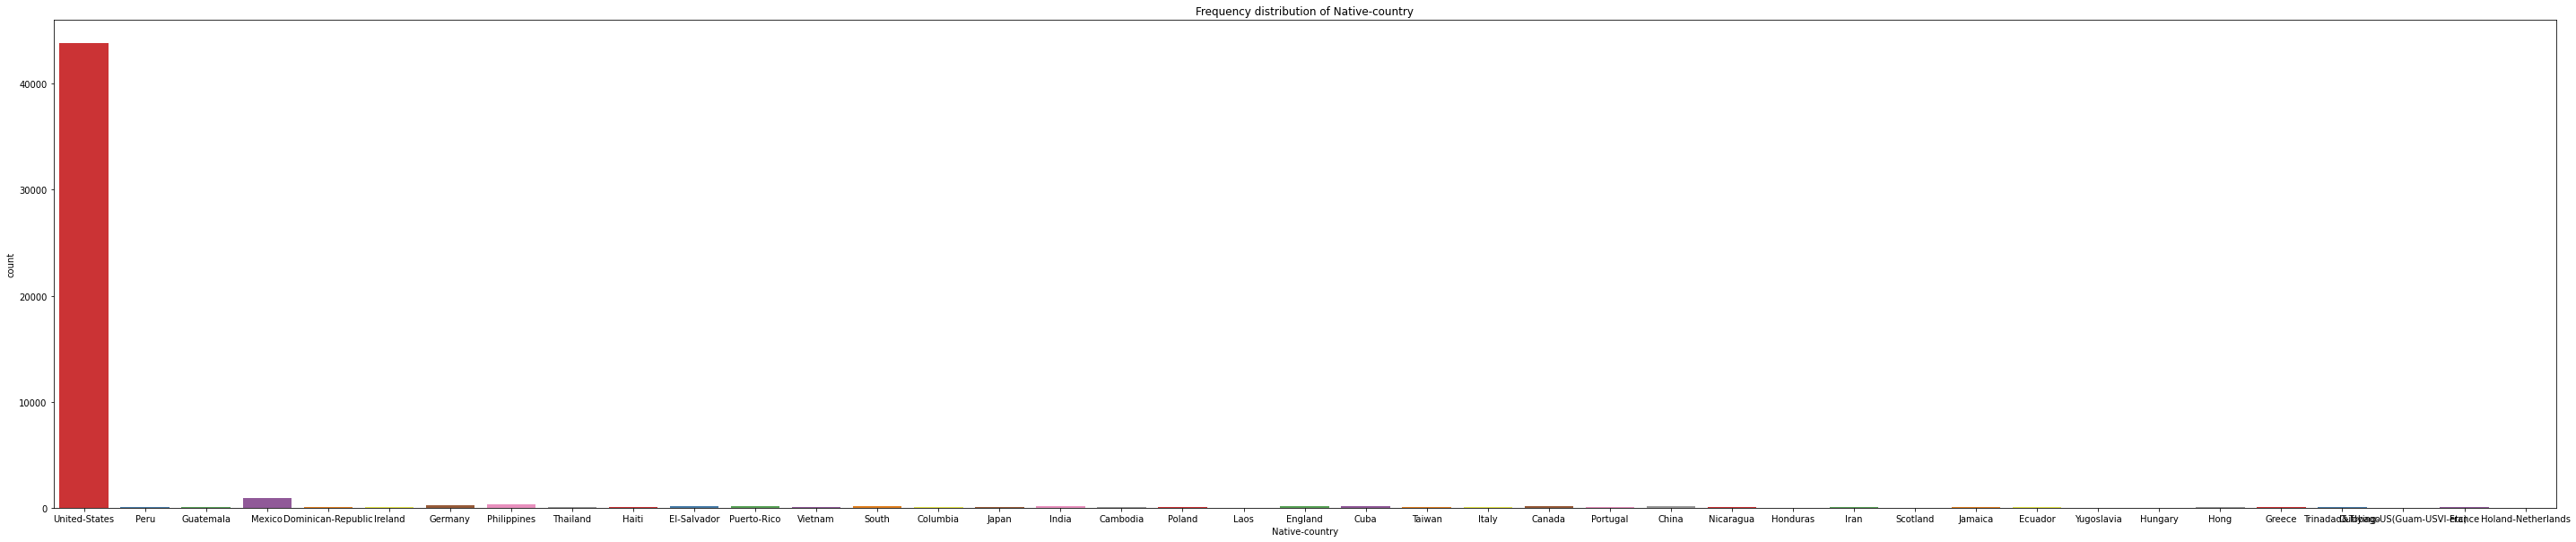

United-States                 43832
Mexico                          951
Philippines                     295
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador                     155
India                           151
Cuba                            138
England                         127
China                           122
South                           115
Jamaica                         106
Italy                           105
Dominican-Republic              103
Japan                            92
Guatemala                        88
Poland                           87
Vietnam                          86
Columbia                         85
Haiti                            75
Portugal                         67
Taiwan                           65
Iran                             59
Nicaragua                        49
Greece                           49
Peru                             46
Ecuador                     

In [130]:
f, ax = plt.subplots(figsize=(50, 10))
ax = sns.countplot(x="Native-country", data=data, palette="Set1")
ax.set_title("Frequency distribution of Native-country")
plt.show()
data['Native-country'].value_counts()

In [133]:
print('% of observations of United-States:',(data[data['Native-country'] == 'United-States'].shape[0] / data.shape[0])*100)

% of observations of United-States: 89.74243478973015


## Data Capping


In [62]:
data_capp = data[
     (data["Age"] <=70) &
     (data["Hours-per-week"] <=70) 
    ]
print("Removed records:",data.shape[0]-data_capp.shape[0])
print("Updated Records:",data_capp.shape)

Removed records: 1629
Updated Records: (47213, 15)


# Data Transformations and encoding

In [259]:
# from feature-engine
from feature_engine import missing_data_imputers as mdi
# for one hot encoding with feature-engine
from feature_engine.categorical_encoders import OneHotCategoricalEncoder
from feature_engine.categorical_encoders import RareLabelCategoricalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.preprocessing import StandardScaler

## Subset

In [333]:
# Dropping Education variable
data_drop = data.drop(['Education','Native-country'], axis=1)
data_sub = data_drop.sample(frac=0.3, replace=False, random_state=42)
# separate into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data_sub.drop('Class', axis=1),  # predictors
    data_sub['Class'],  # target
    test_size=0.1,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((13187, 12), (1466, 12))

### Transformations

In [334]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13187 entries, 930 to 22775
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             13187 non-null  int64 
 1   Workclass       12425 non-null  object
 2   Fnlwgt          13187 non-null  int64 
 3   Education-num   13187 non-null  int64 
 4   Marital-status  13187 non-null  object
 5   Occupation      12423 non-null  object
 6   Relationship    13187 non-null  object
 7   Race            13187 non-null  object
 8   Sex             13187 non-null  object
 9   Capital-gain    13187 non-null  int64 
 10  Capital-loss    13187 non-null  int64 
 11  Hours-per-week  13187 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 1.3+ MB


In [335]:
income_pipe = Pipeline([

    # missing data imputation 
    ('imputer_cat_missing',
     mdi.CategoricalVariableImputer(imputation_method='missing',variables=['Workclass','Occupation'])),

    # categorical encoding 
    ('encoder_rare_label',
     RareLabelCategoricalEncoder(tol=0.01,
                                    n_categories=4,
                                    variables=['Race','Relationship','Occupation','Marital-status','Workclass'])),
    ('categorical_encoder',
     OneHotCategoricalEncoder( top_categories=None,
                               variables=['Race','Relationship','Occupation','Marital-status','Workclass','Sex'], # we can select which variables to encode
                               drop_last=True)),
    ('scaler', SklearnTransformerWrapper(transformer=StandardScaler(), variables = ['Fnlwgt','Age','Capital-gain','Capital-loss','Hours-per-week'])),

])

In [336]:
income_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('imputer_cat_missing',
                 CategoricalVariableImputer(fill_value='Missing',
                                            imputation_method='missing',
                                            return_object=False,
                                            variables=['Workclass',
                                                       'Occupation'])),
                ('encoder_rare_label',
                 RareLabelCategoricalEncoder(max_n_categories=None,
                                             n_categories=4,
                                             replace_with='Rare', tol=0.01,
                                             variables=['Race', 'Relationship',
                                                        'Occupation',
                                                        'M...
                ('categorical_encoder',
                 OneHotCategoricalEncoder(drop_last=True, top_categories=None,
                   

In [337]:
# Apply Transformations
X_train=income_pipe.transform(X_train)
X_test=income_pipe.transform(X_test)

In [338]:
X_train.shape

(13187, 41)

## Whole dataset

In [ ]:
# Dropping Education variable
data.drop(['Education'], axis=1, inplace=True)
# separate into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('Class', axis=1),  # predictors
    data['Class'],  # target
    test_size=0.1,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((43957, 14), (4885, 14))

### Transformations

In [185]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 527 entries, 33704 to 37474
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             527 non-null    int64 
 1   Workclass       497 non-null    object
 2   Fnlwgt          527 non-null    int64 
 3   Education       527 non-null    object
 4   Education-num   527 non-null    int64 
 5   Marital-status  527 non-null    object
 6   Occupation      497 non-null    object
 7   Relationship    527 non-null    object
 8   Race            527 non-null    object
 9   Sex             527 non-null    object
 10  Capital-gain    527 non-null    int64 
 11  Capital-loss    527 non-null    int64 
 12  Hours-per-week  527 non-null    int64 
 13  Native-country  517 non-null    object
dtypes: int64(6), object(8)
memory usage: 61.8+ KB


In [186]:
income_pipe = Pipeline([

    # missing data imputation 
    ('imputer_cat_missing',
     mdi.CategoricalVariableImputer(imputation_method='missing',variables=['Workclass','Occupation','Native-country'])),

    # categorical encoding 
    ('encoder_rare_label',
     RareLabelCategoricalEncoder(tol=0.01,
                                    n_categories=4,
                                    variables=['Native-country','Race','Relationship','Occupation','Marital-status','Education','Workclass'])),
    ('categorical_encoder',
     OneHotCategoricalEncoder( top_categories=None,
                               variables=['Native-country','Race','Relationship','Occupation','Marital-status','Education','Workclass','Sex'], # we can select which variables to encode
                               drop_last=True)),
    ('scaler', SklearnTransformerWrapper(transformer=StandardScaler(), variables = ['Fnlwgt','Age','Capital-gain','Capital-loss','Hours-per-week'])),

])

In [187]:
income_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('imputer_cat_missing',
                 CategoricalVariableImputer(fill_value='Missing',
                                            imputation_method='missing',
                                            return_object=False,
                                            variables=['Workclass',
                                                       'Occupation',
                                                       'Native-country'])),
                ('encoder_rare_label',
                 RareLabelCategoricalEncoder(max_n_categories=None,
                                             n_categories=4,
                                             replace_with='Rare', tol=0.01,
                                             variables=['Native-country',
                                                        'Ra...
                 OneHotCategoricalEncoder(drop_last=True, top_categories=None,
                                          variables=['Native-

In [188]:
# Apply Transformations
X_train=income_pipe.transform(X_train)
X_test=income_pipe.transform(X_test)

# Simple Classifiers

## LogisticRegression

In [307]:
# Train a logistic regression model


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf = LogisticRegression(max_iter=10000)

#define a list of parameters
param_grid = [{'penalty': ['l1','l2'],
              'C':[0.1, 0.001, 1, 10],
              'solver' : ['liblinear', 'saga']},

              {'penalty': ['elasticnet'],
              'C':[0.1, 0.001, 1, 10],
              'l1_ratio': [0.1,0.5, 0.9],
              'solver' : ['saga']}]

grid_log = GridSearchCV(clf, param_grid, cv=6, verbose=0)

grid_log.fit(X_train, y_train)


print("Best Mean Cross-validation score: {:.2f}".format(grid_log.best_score_))
print()

#find best parameters
print('Logistic Regression parameters: ', grid_log.best_params_)

# Check test data set performance
print("Logistic Train Performance: ", grid_log.score(X_train,y_train))
print("Logistic Test Performance: ", grid_log.score(X_test,y_test))



Best Mean Cross-validation score: 0.85

Logistic Regression parameters:  {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Train Performance:  0.8543799772468714
Logistic Test Performance:  0.8548057259713702


## KNN

In [247]:
# Train a KNN model, report the coefficients, the best parameters, and model performance 
# hint: find the optimal k

# YOUR CODE HERE

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

# define a list of parameters
param_knn = {'n_neighbors': range(2,10)}

#apply grid search
grid_knn = GridSearchCV(knn, param_knn, cv=9, return_train_score=True)
grid_knn.fit(X_train, y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(grid_knn.best_score_))
print()

#find best parameters
print('KNN parameters: ', grid_knn.best_params_)

# Check test data set performance
print("KNN Train Performance: ", grid_knn.score(X_train,y_train))
print("KNN Test Performance: ", grid_knn.score(X_test,y_test))

Best Mean Cross-validation score: 0.84

KNN parameters:  {'n_neighbors': 9}
KNN Train Performance:  0.8669093390968036
KNN Test Performance:  0.8382804503582395


## Decision tree with Max_leaf_nodes

In [248]:
# Train a Decision Tree model, report the coefficients, the best parameters, and model performance (10 points)
# hint: find the optimal max_depth

# YOUR CODE HERE
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(random_state=0)

#define a list of parameters
param_dtree = {'max_leaf_nodes': range(3,36),
               'criterion': ['gini', 'entropy'],
               'splitter': ['best','random']}

#apply grid search
grid_dtree = GridSearchCV(dtree, param_dtree, cv=6, return_train_score = True)
grid_dtree.fit(X_train, y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(grid_dtree.best_score_))
print()

#find best parameters
print('Decision Tree parameters: ', grid_dtree.best_params_)

# Check test data set performance
print("Decision Tree Performance Train: ", grid_dtree.score(X_train,y_train))
print("Decision Tree Performance Test: ", grid_dtree.score(X_test,y_test))


Best Mean Cross-validation score: 0.86

Decision Tree parameters:  {'criterion': 'gini', 'max_leaf_nodes': 21, 'splitter': 'best'}
Decision Tree Performance Train:  0.863041747241497
Decision Tree Performance Test:  0.8464687819856704


## SVM Classification Linear

In [300]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

svc_linear = LinearSVC(dual = False, max_iter=10000)

#define a list of parameters
param_svc_linear = {'penalty': ['l1','l2'],
                    'C': [0.08,0.09,0.1, 0.2,0.3,0.4,0.5],
                   }

#apply grid search
grid_param_svc_linear = GridSearchCV(svc_linear, param_svc_linear, cv=4, return_train_score = True)
grid_param_svc_linear.fit(X_train, y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(grid_param_svc_linear.best_score_))
print()

#find best parameters
print('SVC parameters: ', grid_param_svc_linear.best_params_)



# Check test data set performance
print("SVC Performance train: ", grid_param_svc_linear.score(X_train,y_train))
print("SVC Performance test: ", grid_param_svc_linear.score(X_test,y_test))

Best Mean Cross-validation score: 0.85

SVC parameters:  {'C': 0.09, 'penalty': 'l2'}
SVC Performance train:  0.8548350398179749
SVC Performance test:  0.852760736196319


## SVM Classification Kernel:rbf

In [301]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svc_kernel = SVC(kernel = 'rbf')

#define a list of parameters
param_svc_kernel = {'C': [15000,25000,30000],'gamma':[0.0008,0.001,0.003,0.005]}

#apply grid search
grid_svc_kernel = GridSearchCV(svc_kernel, param_svc_kernel, cv=5, n_jobs=2)
grid_svc_kernel.fit(X_train, y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(grid_svc_kernel.best_score_))


#find best parameters
print('SVC parameters: ', grid_svc_kernel.best_params_)

print('train score: ', grid_svc_kernel.score(X_train, y_train))
print('test score: ', grid_svc_kernel.score(X_train, y_train))

Best Mean Cross-validation score: 0.86
SVC parameters:  {'C': 15000, 'gamma': 0.0008}
train score:  0.8741751990898748
test score:  0.8741751990898748


## SVM Classification Kernel: Sigmoid

In [302]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svc_kernel = SVC(kernel = 'sigmoid')

#define a list of parameters
param_svc_kernel = {'C': [1.2,1.4,1.6,1.8],'gamma':[0.08,0.1,0.3,0.5]}

#apply grid search
grid_svc_kernel = GridSearchCV(svc_kernel, param_svc_kernel, cv=5, n_jobs=2)
grid_svc_kernel.fit(X_train, y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(grid_svc_kernel.best_score_))


#find best parameters
print('SVC parameters: ', grid_svc_kernel.best_params_)

print('train score: ', grid_svc_kernel.score(X_train, y_train))
print('test score: ', grid_svc_kernel.score(X_train, y_train))

Best Mean Cross-validation score: 0.75
SVC parameters:  {'C': 1.2, 'gamma': 0.5}
train score:  0.7453924914675768
test score:  0.7453924914675768


## SVM Classification with Poly kernel

In [305]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svc = SVC()

#define a list of parameters
param_svc = {'kernel': ['poly'],  
             'C': [4,6,8,9,10], 
             'degree': [2, 3,5]}
             

#apply grid search
grid_param_svc = GridSearchCV(svc, param_svc, cv=6, return_train_score = True, scoring='accuracy')
grid_param_svc.fit(X_train, y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(grid_param_svc.best_score_))
print()

#find best parameters
print('SVC parameters: ', grid_param_svc.best_params_)



# Check test data set performance
print("SVC Performance train: ", grid_param_svc.score(X_train,y_train))
print("SVC Performance test: ", grid_param_svc.score(X_test,y_test))

Best Mean Cross-validation score: 0.85

SVC parameters:  {'C': 8, 'degree': 3, 'kernel': 'poly'}
SVC Performance train:  0.859613196814562
SVC Performance test:  0.8609406952965235


## Bagging SVC

In [283]:
from sklearn.ensemble import BaggingClassifier

In [309]:
#code snippet reference from classwork
bag_logreg1 = BaggingClassifier(base_estimator=LinearSVC(dual = False, max_iter=10000), bootstrap=True, random_state=0, oob_score=True, n_jobs=-1)

bag_logreg1_param = {
                 'base_estimator__max_iter': [10000],
                 'base_estimator__C': [0.08,0.09,0.1, 0.2,0.3,0.4,0.5],
                 'base_estimator__penalty': ['l1','l2'],
                 'max_samples':  [0.8,1],
                 'n_estimators': [50,100]}
bag_logreg1_grid = GridSearchCV(bag_logreg1, bag_logreg1_param,cv=5, return_train_score=True, )
bag_logreg1_grid.fit(X_train,y_train)
print(f'Best Mean Cross Validation Score is {bag_logreg1_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {bag_logreg1_grid.best_params_}')
print(f'Train score is {bag_logreg1_grid.score(X_train,y_train)}')
print(f'Test score is {bag_logreg1_grid.score(X_test,y_test)}')
#print(f'Val score is {bag_logreg1_grid.score(X_val,y_val)}')

Best Mean Cross Validation Score is 0.8530147895335609
Best Mean Cross Validation Score is {'base_estimator__C': 0.3, 'base_estimator__max_iter': 10000, 'base_estimator__penalty': 'l1', 'max_samples': 0.8, 'n_estimators': 50}
Train score is 0.8548350398179749
Test score is 0.8568507157464212


### Decision Tree

In [310]:
#code snippet reference from classwork
bag_dtree1 = BaggingClassifier(base_estimator=DecisionTreeClassifier(), bootstrap=True, random_state=0, oob_score=True)

bag_dtree1_param = {
                 'base_estimator__max_depth': range(1,10),
                 'max_samples':  [0.8,1],
                 'n_estimators': [50,100,200]}
bag_dtree1_grid = GridSearchCV(bag_dtree1, bag_dtree1_param,cv=5, return_train_score=True, )
bag_dtree1_grid.fit(X_train,y_train)
print(f'Best Mean Cross Validation Score is {bag_dtree1_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {bag_dtree1_grid.best_params_}')
print(f'Train score is {bag_dtree1_grid.score(X_train,y_train)}')
print(f'Test score is {bag_dtree1_grid.score(X_test,y_test)}')
# print(f'Val score is {bag_dtree1_grid.score(X_val,y_val)}')

Best Mean Cross Validation Score is 0.8566552901023889
Best Mean Cross Validation Score is {'base_estimator__max_depth': 9, 'max_samples': 0.8, 'n_estimators': 50}
Train score is 0.8992036405005688
Test score is 0.8588957055214724


## Random Forest

In [ ]:
#code snippet reference from classwork
from sklearn.ensemble import RandomForestClassifier
rfc =RandomForestClassifier(random_state=42)
rfc_param = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2,4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

rfc_grid = GridSearchCV(rfc, rfc_param,cv=5, return_train_score=True,scoring='f1' )
rfc_grid.fit(X_train,y_train)
print(f'Best Mean Cross Validation Score is {rfc_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {rfc_grid.best_params_}')
print(f'Train score is {rfc_grid.score(X_train,y_train)}')
print(f'Test score is {rfc_grid.score(X_test,y_test)}')
#print(f'Val score is {rfc_grid.score(X_val,y_val)}')

## Ada Boost (with decision tree)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

#code snippet reference from classwork
adc_dtree =AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42,algorithm ="SAMME.R")
adc_dtree_param = {
              'base_estimator__criterion' : ["gini", "entropy"],
              'base_estimator__splitter' :   ["best", "random"],
              'base_estimator__max_depth' : [1,2,4],
              'n_estimators' : [150,200,500,1000],
              'learning_rate' : [0.5,1.0,2],
             }
adc_dtree_grid = GridSearchCV(adc_dtree, adc_dtree_param,cv=5, return_train_score=True,scoring='f1' )
adc_dtree_grid.fit(X_train,y_train)
print(f'Best Mean Cross Validation Score is {adc_dtree_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {adc_dtree_grid.best_params_}')
print(f'Train score is {adc_dtree_grid.score(X_train,y_train)}')
print(f'Test score is {adc_dtree_grid.score(X_test,y_test)}')
#print(f'Val score is {adc_dtree_grid.score(X_val,y_val)}')

## Gradient Boost

In [339]:
#code snippet reference from classwork

from  sklearn.ensemble import GradientBoostingClassifier
gbc= GradientBoostingClassifier(random_state=42)
gbc_param = {
              'max_depth' : range(2,15),
              'n_estimators' : [20,50,100,150],
              'learning_rate' : [0.01,0.1],
             }
gbc_grid = GridSearchCV(gbc, gbc_param,cv=5, return_train_score=True, scoring='f1')
gbc_grid.fit(X_train,y_train)
print(f'Best Mean Cross Validation Score is {gbc_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {gbc_grid.best_params_}')
print(f'Train score is {gbc_grid.score(X_train,y_train)}')
print(f'Test score is {gbc_grid.score(X_test,y_test)}')
#print(f'Val score is {gbc_grid.score(X_val,y_val)}')

Best Mean Cross Validation Score is 0.7089491589993475
Best Mean Cross Validation Score is {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}
Train score is 0.7859391395592865
Test score is 0.715927750410509


## Extra-Trees

In [340]:
#code snippet reference from classwork

from  sklearn.ensemble import ExtraTreesClassifier
etc= ExtraTreesClassifier(random_state=42)
etc_param = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1,2,4,5],
    'criterion' :['gini', 'entropy']
}
etc_grid = GridSearchCV(etc, etc_param,cv=5, return_train_score=True,scoring='f1' )
etc_grid.fit(X_train,y_train)
print(f'Best Mean Cross Validation Score is {etc_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {etc_grid.best_params_}')
print(f'Train score is {etc_grid.score(X_train,y_train)}')
print(f'Test score is {etc_grid.score(X_test,y_test)}')
#print(f'Val score is {etc_grid.score(X_val,y_val)}')

Best Mean Cross Validation Score is 0.5022027185365956
Best Mean Cross Validation Score is {'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 200}
Train score is 0.5095105791835862
Test score is 0.5090180360721442


## XGBoost

In [317]:
pip install xgboost

In [ ]:
#code snippet reference from classwork

from  xgboost import XGBClassifier
xgbc= XGBClassifier(random_state=42,early_stopping_rounds=2,objective= 'binary:logistic')
xgbc_param = {
              'max_depth' : [2,4,6],
              'n_estimators' : [150,200],
              'learning_rate' : [0.1,0.5],
               'min_child_weight' : [1,3,5,7],
                'subsample':[0.8,0.9,1]
             }
xgbc_grid = GridSearchCV(xgbc, xgbc_param,cv=5, return_train_score=True, )
xgbc_grid.fit(X_train,y_train)
print(f'Best Mean Cross Validation Score is {xgbc_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {xgbc_grid.best_params_}')
print(f'Train score is {xgbc_grid.score(X_train,y_train)}')
print(f'Test score is {xgbc_grid.score(X_test,y_test)}')
#print(f'Val score is {xgbc_grid.score(X_val,y_val)}')

Best Mean Cross Validation Score is 0.8514052795031055
Best Mean Cross Validation Score is {'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 150, 'subsample': 0.9}
Train score is 0.8951310861423221
Test score is 0.8333333333333334
